In [1]:
# Working directory set
import sys
sys.path.append("../scripts/")

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from clean_data import load_and_clean_data

pd.set_option('display.max_rows', 400)

In [3]:
from sklearn.feature_selection import mutual_info_classif

def mutual_information_ranking(X, y):
    """
    Use mutual information to rank features by importance
    """
    
    mi_scores = mutual_info_classif(X, y)

    mi_features = pd.Series(dict(zip(X.columns, mi_scores)))

    return mi_features.sort_values(ascending=False)


def pairwise_correlation_ranking(X, threshold):
    """
    Returns pairwise correlation of features ranked by absolute value, if above a certain threshold
    """
    
    corr = X.corr()
    
    corrdict = {}
    for i in range(len(corr)):
        for j in range(len(corr.columns)):
            if i != j and np.abs(corr.iloc[i,j] > threshold):
                corrdict[tuple(sorted([corr.columns[i], corr.columns[j]]))] = corr.iloc[i,j]
    return np.array(sorted(corrdict.items(), key=lambda x: np.abs(x[1]), reverse=True), dtype=object)



def filter_by_correlation(X, y, threshold=0.85):
    """
    Greedy filtering of features by correlation
    """
    correlations = pairwise_correlation_ranking(X, threshold)
    while len(correlations) > 0:
        worst_feature = mutual_information_ranking(X[list(correlations[0][0])], y).idxmin()
        X.drop(worst_feature, axis=1, inplace=True)
        correlations = pairwise_correlation_ranking(X, threshold)
    return X

def run_baseline_dt(X_train, y_train, X_val, y_val):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    importances = {}
    for name, importance in zip(X_val.columns, dt.feature_importances_):
        importances[name] = importance
        
    imp = pd.DataFrame.from_dict(importances, orient = 'index', columns = ['importance'])
    imp.sort_values(by = 'importance', ascending = False, inplace = True)
    
    return fpr, tpr, roc_auc, imp

In [4]:
X_train, X_test, y_train, y_test = load_and_clean_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

/var/folders/dp/df65_q2x4lv3t41057t55p780000gn/T/ipykernel_69042/960417569.py:1: DtypeWarning: Columns (10,17,19,23,25,27,28,29,30,32,33,36,37,38,39,40,41,42,43,50,51,83,86,89,92,94,95,97,100,103,106,110,113,116,121,124,127,130,133,136,188,190,201,212,231,232,242,244,247,249,256,262,267,273,279,280,281,282,283,284,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,305,318,320,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train, X_test, y_train, y_test = load_and_clean_data()
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
../scripts/clean_data.py:257: PerformanceWarning: DataFrame is highly fragmented.  T

In [5]:
fpr, tpr, roc_auc, imp = run_baseline_dt(X_train, y_train, X_val, y_val)

In [6]:
#drop columns that have 0 feature importance
imp.reset_index(inplace = True)

imp.drop(np.where(imp.importance == 0)[0], inplace = True)

cols_to_keep = np.array(imp['index'])

X2_train = X_train[cols_to_keep]

In [7]:
X2_train.shape

(150286, 307)

In [8]:
np.arange(1.0, 0, -0.05)

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05])

In [9]:
thresholds = np.arange(1.0, 0, -0.05)
features_left = []

for t in thresholds:
    X_train_corr = filter_by_correlation(X2_train, y_train, t)
    features_left.append(X_train_corr.shape[1])
    print(f'Done with {t}!')

Done with 1.0!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.95!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Done with 0.8999999999999999!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Done with 0.8499999999999999!
Done with 0.7999999999999998!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.7499999999999998!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Done with 0.6999999999999997!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Done with 0.6499999999999997!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Done with 0.5999999999999996!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.5499999999999996!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.49999999999999956!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.4499999999999995!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.39999999999999947!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.3499999999999994!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.2999999999999994!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.24999999999999933!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.1999999999999993!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.14999999999999925!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.0999999999999992!


/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/kpant/.pyenv/versions/3.9.1/envs/cs/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Done with 0.049999999999999156!


In [10]:
import matplotlib.pyplot as plt

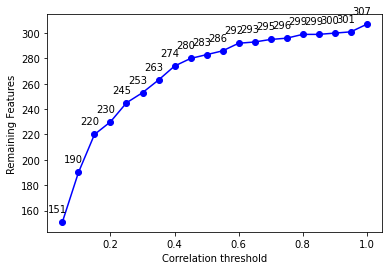

In [11]:
plt.plot(thresholds, features_left, 'bo-')
for x,y in zip(thresholds, features_left):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.xlabel('Correlation threshold')
plt.ylabel('Remaining Features')
plt.show()